<h1 align="center" style="background-color:yellow;">Feature Engineering Project - Web Scrapping</h1>

In [1]:
'''
!pip install scrapy
!pip install tabulate
'''

'\n!pip install scrapy\n!pip install tabulate\n'

In [2]:
import os
import logging
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scrapy
from scrapy.crawler import CrawlerProcess
from glob import glob
import glob, os
from ipywidgets import widgets
from IPython.display import display, clear_output
from tabulate import tabulate
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

In [3]:
CONST_USER_AGENT = 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'

CONST_PRODUCT = 'Product'
CONST_URL = 'Url'
CONST_PLATFORM = 'Platform'

CONST_MAX_PAGE_COUNT = 'Max_Page_Count'
CONST_PRODUCT_NAME = 'Product_Name'
CONST_PRODUCT_COST = 'Product_Cost'

CONST_PRODUCT_BEVERAGES = 'Beverages'
CONST_PRODUCT_BEVERAGES_TEA = 'Tea'
CONST_PRODUCT_BEVERAGES_COFFEE = 'Coffee'
CONST_PRODUCT_GROCERRIES = 'Grocery'
CONST_PRODUCT_MASALA_AND_SPICES = 'Masala & Spices'

CONST_PLATFORM_BIGBASKET = 'BigBasket'
CONST_PLATFORM_DMART = 'Dmart'
CONST_PLATFORM_AMAZON = 'Amazon'
CONST_PLATFORM_FLIPKART = 'Flipkart'

CONST_DF_FORMAT_CSV = '.csv'
CONST_DF_FORMAT_JSON = '.json'

CONST_NOT_APPLICABLE = 'N/A'

<h2 align="center" style="background-color:yellow;">(A) DATA ACQUISITION</h2>
<h3>Data Scrapped from the following platforms</h3>
<ol style="font-style:italic; font-weight:normal">
  <li>Amazon</li>
  <li>Big Basket</li>
  <li>DMart</li>
  <li>Flipkart</li>
</ol>

In [4]:
DF_Save_Format = CONST_DF_FORMAT_CSV
class Base_Spider():
    ''' This is the base class for all the custom data scrappers. '''
    
    def __init__():
        ''' Base Constructor'''
        
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'FEED_FORMAT':'csv',
    }
        
    def save(self, df, filename, domain):
        path = 'outputs'
        if not os.path.exists(path):
            os.makedirs(path)
        if DF_Save_Format == CONST_DF_FORMAT_CSV:
            df.to_csv(path + '/' + domain + '_' + filename + CONST_DF_FORMAT_CSV)
        elif DF_Save_Format == CONST_DF_FORMAT_JSON:
            df.to_json(path + '/' + domain + '_' + filename + CONST_DF_FORMAT_JSON)

In [5]:
class Amazon_Spider(scrapy.Spider, Base_Spider):
    ''' Spider to crawl data from Amazon sites. '''
    
    name = 'amazon'
    product = None
    allowed_domains = ['amazon.in']    
    url = None
    max_page_count = 0
    custom_settings = {
        **Base_Spider.custom_settings,
        'FEED_URI': 'outputs/amazonresult' + DF_Save_Format
    }
    
    def __init__(self, product=None, url = None, max_page_count = None, *args, **kwargs):
        super(Amazon_Spider, self).__init__(*args, **kwargs)
        self.product = product
        self.start_urls.append(url)        
    
    def parse(self, response):
        if response.status == 200:            
            for url in response.xpath('//ul[@id="zg_browseRoot"]/ul/ul/li/a/@href').extract():
                yield scrapy.Request(url = url, callback = self.parse_product, errback = self.errback_httpbin, dont_filter=True)            
            
    def parse_product(self, response): 
             
        #Extract data using css selectors
        for product in response.xpath('//ol[@id="zg-ordered-list"]//li[@class="zg-item-immersion"]').extract():
            product_name = response.xpath('//li[@class="zg-item-immersion"]//div[@class="a-section a-spacing-small"]/img/@alt').extract()
            product_price = response.xpath('//span[@class="p13n-sc-price"]/text()').extract()         
            product_rating = response.xpath('//div[@class="a-icon-row a-spacing-none"]/a/@title').extract()
            #product_category = response.xpath('//span[@class="category"]/text()').extract()            
        
        #Making extracted data row wise
        for item in zip(product_name,product_price,product_rating):
            #create a dictionary to store the scraped info
            scraped_info = {
                #key:value
                'product_name' : item[0], #item[0] means product in the list and so on, index tells what value to assign
                'price' : item[1],
                'rating' : item[2],
                'category' : response.xpath('//span[@class="category"]/text()').extract(),
            }
            yield scraped_info
                              
    def errback_httpbin(self, failure):
        # log all failures
        # in case you want to do something special for some errors,
        # you may need the failure's type:

        if failure.check(HttpError):
            # these exceptions come from HttpError spider middleware
            # you can get the non-200 response
            response = failure.value.response
            self.logger.error('HttpError on %s', response.url)

In [6]:
class BigBasket_Spider(scrapy.Spider, Base_Spider):
    ''' Spider to crawl data from BigBasket sites. '''
    
    name = 'bigbasket'
    allowed_domains = ['bigbasket.com']
    max_page_count = 0
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
    }
    
    def __init__(self, product=None, url = None, max_page_count = None, *args, **kwargs):
        super(BigBasket_Spider, self).__init__(*args, **kwargs)
        self.product = product
        if self.product == CONST_PRODUCT_BEVERAGES_TEA:
            for i in range(2, int(max_page_count)):
                self.start_urls.append(url[0:(url.rfind('page=')+5)] + str(i) + url[(url.rfind('page=')+6):])
        elif self.product == CONST_PRODUCT_BEVERAGES_COFFEE:
            for i in range(2, int(max_page_count)):
                self.start_urls.append(url[0:(url.rfind('page=')+5)] + str(i) + url[(url.rfind('page=')+6):])
            
    def get_json(self, response):
        if self.product == CONST_PRODUCT_BEVERAGES_TEA or self.product == CONST_PRODUCT_BEVERAGES_COFFEE:
            return json.loads(response.body)['tab_info']['product_map']['all']['prods']
    
    def parse(self, response):
        url = str(response.url)
        data = self.get_json(response)
        cols= ['p_desc', 'mrp', 'sp', 'dis_val', 'w','store_availability', 'rating_info']
        df = pd.DataFrame(columns = cols)
        for item in data:    
            df = df.append(pd.Series({k: item[k]  if k != 'store_availability' else 'A' \
                  in [i['pstat'] for i in item[k]] if k != 'rating_info' else item['rating_info']['avg_rating'] for k in cols}), ignore_index = True)
        df[['dis_val','mrp','sp']] = df[['dis_val','mrp','sp']].apply(pd.to_numeric)
        df['dis_val'].fillna(0, inplace=True)
        df['dis_val'] = (df['mrp']/100) * df['dis_val']
        #display(df)
        self.save(df, self.product + '_' + str(url[url.rfind('page=') + 5:url.rfind('&tab_type')]), BigBasket_Spider.name)

In [7]:
class Dmart_Spider(scrapy.Spider, Base_Spider):
    ''' Spider to crawl data from Dmart sites. '''
    
    name = 'dmart'
    allowed_domains = ['dmart.in']
    max_page_count = 0
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
    }
    
    def __init__(self, product=None, url = None, max_page_count = None, *args, **kwargs):
        super(Dmart_Spider, self).__init__(*args, **kwargs)
        self.product = product
        if self.product == CONST_PRODUCT_BEVERAGES or self.product == CONST_PRODUCT_GROCERRIES or self.product == CONST_PRODUCT_MASALA_AND_SPICES:
            self.start_urls.append(url)
            
    def get_json(self, response):
        if self.product == CONST_PRODUCT_BEVERAGES or self.product == CONST_PRODUCT_MASALA_AND_SPICES:
            return json.loads(response.body)['products']['suggestionView']
        elif self.product == CONST_PRODUCT_GROCERRIES:
            return json.loads(response.body)['suggestionView']
    
    def parse(self, response):
        data = self.get_json(response)
        cols= ['name', 'price_MRP', 'price_SALE', 'save_price', 'defining','buyable']
        df = pd.DataFrame(columns = cols)
        for item in data:#
            df = df.append(pd.Series({k: item['skus'][0].get(k)  for k in cols}), ignore_index = True)
        #print('\n---------------------------------' + self.product + '-------------------------------------------')
        #display(df)
        self.save(df, self.product, Dmart_Spider.name)

In [8]:
class Flipkart_Spider(scrapy.Spider, Base_Spider):
    ''' Spider to crawl data from Flipkart sites. '''
    
    name = 'flipkart'
    allowed_domains = ['flipkart.in']
    max_page_count = 0
    
    custom_settings = {
        **Base_Spider.custom_settings,
        'FEED_URI': 'outputs/flipkartresult' + DF_Save_Format
    }
    
    def __init__(self, product=None, url = None, max_page_count = None, *args, **kwargs):
        super(Flipkart_Spider, self).__init__(*args, **kwargs)
        self.product = product
        self.start_urls = [
            'https://www.flipkart.com/search?q=beverages%20in%20tea&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off',
            'https://www.flipkart.com/search?q=tea&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=2',
            'https://www.flipkart.com/search?q=tea&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=3',
            'https://www.flipkart.com/search?q=coffee&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off',
            'https://www.flipkart.com/search?q=coffee&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=2',
            'https://www.flipkart.com/search?q=coffee&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=3',
            'https://www.flipkart.com/search?q=spices&as=on&as-show=on&otracker=AS_Query_OrganicAutoSuggest_4_4_na_na_na&otracker1=AS_Query_OrganicAutoSuggest_4_4_na_na_na&as-pos=4&as-type=RECENT&suggestionId=spices&requestId=94f8bdaf-8357-487a-a68b-e909565784e7&as-searchtext=s%5Bpic',
            'https://www.flipkart.com/search?q=spices&as=on&as-show=on&otracker=AS_Query_OrganicAutoSuggest_4_4_na_na_na&otracker1=AS_Query_OrganicAutoSuggest_4_4_na_na_na&as-pos=4&as-type=RECENT&suggestionId=spices&requestId=94f8bdaf-8357-487a-a68b-e909565784e7&as-searchtext=s%5Bpic&page=2',
            'https://www.flipkart.com/search?q=spices&as=on&as-show=on&otracker=AS_Query_OrganicAutoSuggest_4_4_na_na_na&otracker1=AS_Query_OrganicAutoSuggest_4_4_na_na_na&as-pos=4&as-type=RECENT&suggestionId=spices&requestId=94f8bdaf-8357-487a-a68b-e909565784e7&as-searchtext=s%5Bpic&page=3',
            'https://www.flipkart.com/search?q=grocery&sid=7jv%2Cp3n%2C0ed&as=on&as-show=on&otracker=AS_QueryStore_OrganicAutoSuggest_2_8_na_na_ps&otracker1=AS_QueryStore_OrganicAutoSuggest_2_8_na_na_ps&as-pos=2&as-type=RECENT&suggestionId=grocery%7CDals+%26+Pulses&requestId=749df6fb-1916-45df-a5f6-e2445a67b7ce&as-searchtext=grocery%20',
            'https://www.flipkart.com/search?q=grocery&sid=7jv%2Cp3n%2C0ed&as=on&as-show=on&otracker=AS_QueryStore_OrganicAutoSuggest_2_8_na_na_ps&otracker1=AS_QueryStore_OrganicAutoSuggest_2_8_na_na_ps&as-pos=2&as-type=RECENT&suggestionId=grocery%7CDals+%26+Pulses&requestId=749df6fb-1916-45df-a5f6-e2445a67b7ce&as-searchtext=grocery+&page=2',
            'https://www.flipkart.com/search?q=grocery+1+rs+offer+all&sid=7jv%2C72u%2Cd6s&as=on&as-show=on&otracker=AS_QueryStore_OrganicAutoSuggest_6_7_na_na_ps&otracker1=AS_QueryStore_OrganicAutoSuggest_6_7_na_na_ps&as-pos=6&as-type=RECENT&suggestionId=grocery+1+rs+offer+all%7CEdible+Oils&requestId=c19eb0d1-779c-4ae6-9b5a-3f156db29852&as-searchtext=grocery',
            'https://www.flipkart.com/search?q=grocery&sid=7jv%2C30b%2Cpne&as=on&as-show=on&otracker=AS_QueryStore_OrganicAutoSuggest_4_7_na_na_ps&otracker1=AS_QueryStore_OrganicAutoSuggest_4_7_na_na_ps&as-pos=4&as-type=RECENT&suggestionId=grocery%7CNuts+%26+Dry+Fruits&requestId=06270ce4-4dc6-4669-9a72-ce708331f98b&as-searchtext=grocery',
        ]
    
    def parse(self, response):
        for p in response.css('div._3liAhj'):
            yield {
                'Category': response.css('span._2yAnYN span::text').extract_first(),
                'itemname': p.css('a._2cLu-l::text').extract_first(),
                'price(₹)': p.css('a._1Vfi6u div._1uv9Cb div._1vC4OE::text').extract_first()[1:],
                'MRP(₹)' : p.css('a._1Vfi6u div._1uv9Cb div._3auQ3N::text').extract(),
                'discount': p.css('a._1Vfi6u div._1uv9Cb div.VGWI6T span::text').extract_first(),
                'rating': p.css('div.hGSR34::text').extract_first(),
                'itemsdeliverable' : p.css('span._1GJ2ZM::text').extract()
            }

In [9]:
process = CrawlerProcess({
    #'USER_AGENT': CONST_USER_AGENT,
    'LOG_ENABLED' : False
})
products = [
    {
        CONST_PLATFORM : CONST_PLATFORM_BIGBASKET,
        CONST_PRODUCT: CONST_PRODUCT_BEVERAGES_TEA,
        CONST_URL : 'https://www.bigbasket.com/product/get-products/?slug=tea&page=1&tab_type=[%22all%22]&sorted_on=relevance&listtype=ps',
        CONST_MAX_PAGE_COUNT:'10'
    },
    {
        CONST_PLATFORM : CONST_PLATFORM_BIGBASKET,
        CONST_PRODUCT: CONST_PRODUCT_BEVERAGES_COFFEE,
        CONST_URL : 'https://www.bigbasket.com/product/get-products/?slug=coffee&page=1&tab_type=[%22all%22]&sorted_on=relevance&listtype=ps',
        CONST_MAX_PAGE_COUNT:'10'
    },
    {
        CONST_PLATFORM : CONST_PLATFORM_AMAZON,
        CONST_PRODUCT: CONST_PRODUCT_BEVERAGES_TEA,
        CONST_URL: 'https://www.amazon.in/gp/bestsellers/grocery/ref=zg_bs_nav_0',
        CONST_MAX_PAGE_COUNT:'1'
    },
    {
        CONST_PLATFORM : CONST_PLATFORM_DMART,
        CONST_PRODUCT : CONST_PRODUCT_BEVERAGES,
        CONST_URL : 'https://digital.dmart.in/api/v1/clp/15504?page=1&size=1000',
        CONST_MAX_PAGE_COUNT : '1'
    },
    {
        CONST_PLATFORM : CONST_PLATFORM_DMART,
        CONST_PRODUCT : CONST_PRODUCT_GROCERRIES,
        CONST_URL : 'https://digital.dmart.in/api/v1/search/grocery?page=1&size=1000',
        CONST_MAX_PAGE_COUNT : '1'
    },
    {
        CONST_PLATFORM : CONST_PLATFORM_DMART,
        CONST_PRODUCT : CONST_PRODUCT_MASALA_AND_SPICES,
        CONST_URL : 'https://digital.dmart.in/api/v1/clp/15578?page=1&size=1000',
        CONST_MAX_PAGE_COUNT : '1'
    },
    {
        CONST_PLATFORM : CONST_PLATFORM_FLIPKART,
        CONST_PRODUCT : None,
        CONST_URL : None,
        CONST_MAX_PAGE_COUNT : '1'
    },
]
for item in products:
    
    if item[CONST_PLATFORM] == CONST_PLATFORM_DMART:
        process.crawl(Dmart_Spider, item[CONST_PRODUCT], item[CONST_URL], item[CONST_MAX_PAGE_COUNT])
        #continue
    elif item[CONST_PLATFORM] == CONST_PLATFORM_AMAZON:
        process.crawl(Amazon_Spider, item[CONST_PRODUCT], item[CONST_URL], item[CONST_MAX_PAGE_COUNT])
        #continue
    elif item[CONST_PLATFORM] == CONST_PLATFORM_BIGBASKET:
        process.crawl(BigBasket_Spider, item[CONST_PRODUCT], item[CONST_URL], item[CONST_MAX_PAGE_COUNT])
        #continue
    elif item[CONST_PLATFORM] == CONST_PLATFORM_FLIPKART:
        process.crawl(Flipkart_Spider, item[CONST_PRODUCT], item[CONST_URL], item[CONST_MAX_PAGE_COUNT])
        #continue
process.start()

<h2 align="center" style="background-color:yellow;">(B) DATA CLEANING</h2>

In [10]:
df_amazon = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "outputs/amazon*.csv"))))
df_amazon.head()

,product_name,price,rating,category
0,"Henfruit Farm White Eggs, 30 Pcs",₹ 160.00,3.8 out of 5 stars,"Meat, Poultry & Seafood"
1,Fresh Eggs - 30 Piece,₹ 185.00,3.0 out of 5 stars,"Meat, Poultry & Seafood"
2,Fresh Eggs - 12 Piece,₹ 649.00,3.5 out of 5 stars,"Meat, Poultry & Seafood"
3,Prabhat Fresh Eggs Pack of 12,₹ 140.00,3.9 out of 5 stars,"Meat, Poultry & Seafood"
4,Prabhat Fresh Eggs Pack of 30,₹ 180.00,3.5 out of 5 stars,"Meat, Poultry & Seafood"


In [11]:
# df_amazon[df_amazon.duplicated(['product_name'])]
df_amazon.drop_duplicates(subset ="product_name", keep = 'first', inplace = True) 

In [12]:
df_amazon[df_amazon['product_name'] == 'product_name'].head()

,product_name,price,rating,category
649,product_name,price,rating,category


In [13]:
df_amazon[df_amazon['product_name'] == 'product_name'].shape

(1, 4)

In [14]:
df_amazon.drop(df_amazon[df_amazon['product_name'] == 'product_name'].index, inplace = True)

In [15]:
df_amazon['rating'].unique()

array(['3.8 out of 5 stars', '3.0 out of 5 stars', '3.5 out of 5 stars',
       '3.9 out of 5 stars', '4.0 out of 5 stars', '4.2 out of 5 stars',
       '3.6 out of 5 stars', '4.1 out of 5 stars', '4.4 out of 5 stars',
       '4.5 out of 5 stars', '3.7 out of 5 stars', '4.3 out of 5 stars',
       '2.7 out of 5 stars', '1.0 out of 5 stars', '2.5 out of 5 stars',
       '4.6 out of 5 stars', '4.8 out of 5 stars', '2.9 out of 5 stars',
       '3.3 out of 5 stars', '3.2 out of 5 stars', '2.3 out of 5 stars',
       '1.3 out of 5 stars', '4.7 out of 5 stars', '5.0 out of 5 stars',
       '3.1 out of 5 stars', '3.4 out of 5 stars', '2.4 out of 5 stars',
       '2.8 out of 5 stars', '2.6 out of 5 stars', '2.2 out of 5 stars',
       '2.0 out of 5 stars', '4', '.', '3', ' ', 'o', 'u', 't', '0'],
      dtype=object)

In [16]:
exclude = [' ', '.','o', 'u', 't' ]
df_amazon.drop(df_amazon[df_amazon['rating'].isin(exclude)].index, inplace = True)

In [17]:
df_amazon['rating'] = df_amazon.apply(lambda x: x.rating[0:3] ,axis=1)

In [18]:
df_amazon['price'] = df_amazon['price'].replace('₹', '', regex=True).replace(',', '', regex=True)

In [19]:
df_amazon['price'] = df_amazon['price'].replace('\xa0', '', regex=True)

In [20]:
df_amazon['price'] = df_amazon['price'].str.strip()

In [21]:
df_amazon.drop(df_amazon[df_amazon['price'] == ''].index, inplace = True)

In [22]:
df_amazon.dtypes

product_name    object
price           object
rating          object
category        object
dtype: object

In [23]:
df_amazon['rating'].unique()

array(['3.8', '3.0', '3.5', '3.9', '4.0', '4.2', '3.6', '4.1', '4.4',
       '4.5', '3.7', '4.3', '2.7', '1.0', '2.5', '4.6', '4.8', '2.9',
       '3.3', '3.2', '2.3', '1.3', '4.7', '5.0', '3.1', '3.4', '2.4',
       '2.8', '2.6', '2.2', '2.0', '3', '0', '4'], dtype=object)

In [24]:
df_amazon[['rating', 'price']] = df_amazon[['rating', 'price']].astype(np.float)

In [25]:
df_amazon['SpecialPrice']  = df_amazon['price']
df_amazon['Discount']  = 0.0

In [26]:
df_amazon['IsAvailable']  = True

In [27]:
df_amazon['Platform']  = CONST_PLATFORM_AMAZON

In [28]:
df_amazon.columns

Index(['product_name', 'price', 'rating', 'category', 'SpecialPrice',
       'Discount', 'IsAvailable', 'Platform'],
      dtype='object')

In [29]:
df_amazon.columns = ['ProductName', 'ActualPrice', 'Rating', 'Category', 'SpecialPrice', 'Discount','IsAvailable', 'Platform']

In [30]:
df_amazon.dtypes

ProductName      object
ActualPrice     float64
Rating          float64
Category         object
SpecialPrice    float64
Discount        float64
IsAvailable        bool
Platform         object
dtype: object

In [31]:
df_amazon.head()

,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable,Platform
0,"Henfruit Farm White Eggs, 30 Pcs",160.0,3.8,"Meat, Poultry & Seafood",160.0,0.0,True,Amazon
1,Fresh Eggs - 30 Piece,185.0,3.0,"Meat, Poultry & Seafood",185.0,0.0,True,Amazon
2,Fresh Eggs - 12 Piece,649.0,3.5,"Meat, Poultry & Seafood",649.0,0.0,True,Amazon
3,Prabhat Fresh Eggs Pack of 12,140.0,3.9,"Meat, Poultry & Seafood",140.0,0.0,True,Amazon
4,Prabhat Fresh Eggs Pack of 30,180.0,3.5,"Meat, Poultry & Seafood",180.0,0.0,True,Amazon


In [32]:
df_amazon.isna().any()

ProductName     False
ActualPrice     False
Rating          False
Category        False
SpecialPrice    False
Discount        False
IsAvailable     False
Platform        False
dtype: bool

In [33]:
df_bigbasket = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "outputs/bigbasket*.csv"))))
df_bigbasket.head()

,Unnamed: 0,p_desc,mrp,sp,dis_val,w,store_availability,rating_info
0,0,Nilgiri Green Tea - Seiki Peppermint,550.0,550.0,0.0,125 g,True,{'sku_id': 40187583}
1,1,Nilgiri Green Tea - Taido Ginger,750.0,750.0,0.0,100 g,True,{'sku_id': 40187598}
2,2,Nilgiri Green Tea - Yakuso Tulsi,550.0,550.0,0.0,125 g,True,{'sku_id': 40187578}
3,3,Nilgiri Green Tea - Taizen Cinnamon,550.0,550.0,0.0,125 g,True,{'sku_id': 40187580}
4,4,Nilgiris Green Tea - Yoshin Lemon,550.0,550.0,0.0,125 g,True,{'sku_id': 40187582}


In [34]:
df_bigbasket.shape

(320, 8)

In [35]:
df_bigbasket.drop('Unnamed: 0', axis=1,inplace=True)

In [36]:
df_bigbasket.drop('w', axis=1,inplace=True)

In [37]:
df_bigbasket['rating_info'].fillna(CONST_NOT_APPLICABLE, inplace = True)

In [38]:
def get_bigbasket_ratings(x):
    if 'avg_rating' in x:
        rating_index = x.rfind('avg_rating')
        l = len('avg_rating')
        m = x[(rating_index+l):].find(',')
        n = x[(rating_index+l) : (rating_index+l + m)].split(':')
        if len(n) > 1:
            return n[1]
        else:
            return n[0]
    else:
        return CONST_NOT_APPLICABLE

In [39]:
df_bigbasket['rating_info'] = df_bigbasket.apply(lambda x: get_bigbasket_ratings(x.rating_info), axis=1)

In [40]:
df_bigbasket['rating_info'].unique()

array(['N/A', ' 1', ' 5', ' 3', ' 4.1', ' 4.2', ' 4.4', ' 4.3', ' 3.5',
       ' 3.2', ' 2.5', ' 4.6', ' 4.7', ' 4.8', ' 4', ' 4.5', ' 3.7',
       ' 3.6', ' 3.9'], dtype=object)

In [41]:
df_bigbasket['Category'] = CONST_PRODUCT_BEVERAGES
df_bigbasket['Platform']  = CONST_PLATFORM_BIGBASKET

In [42]:
df_bigbasket.columns

Index(['p_desc', 'mrp', 'sp', 'dis_val', 'store_availability', 'rating_info',
       'Category', 'Platform'],
      dtype='object')

In [43]:
df_bigbasket.columns = df_bigbasket.columns = ['ProductName', 'ActualPrice', 'SpecialPrice', 'Discount','IsAvailable', 'Rating', 'Category', 'Platform']

In [44]:
df_bigbasket.dtypes

ProductName      object
ActualPrice     float64
SpecialPrice    float64
Discount        float64
IsAvailable        bool
Rating           object
Category         object
Platform         object
dtype: object

In [45]:
df_bigbasket[df_bigbasket['Rating'] != CONST_NOT_APPLICABLE].head()

,ProductName,ActualPrice,SpecialPrice,Discount,IsAvailable,Rating,Category,Platform
8,Darjeeling Green Tea - Ahina Long Leaf,550.0,550.0,0.0,True,1,Beverages,BigBasket
10,Darjeeling Black Tea - Bodh Second Flush,550.0,550.0,0.0,True,5,Beverages,BigBasket
11,Lemon Green Tea Bags,130.0,130.0,0.0,True,5,Beverages,BigBasket
0,Oolong Tea - Tapas,800.0,800.0,0.0,True,5,Beverages,BigBasket
1,Green Tea - Avana,800.0,800.0,0.0,True,3,Beverages,BigBasket


In [46]:
df_dmart = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "outputs/dmart*.csv"))))
df_dmart.head()

,Unnamed: 0,name,price_MRP,price_SALE,save_price,defining,buyable
0,0,Premia Jeera : 100 gms,32.0,27.0,5.0,[{'volume': '100 gm'}],True
1,1,Premia Dry Coconut : 200 gms,87.0,60.0,27.0,[{'volume': '200 gm'}],True
2,2,Premia Til White : 100 gms,31.0,25.0,6.0,[{'volume': '100 gm'}],True
3,3,Everest Garam Masala : 100 gms,78.0,72.0,6.0,[{'volume': '100 gm'}],True
4,4,Everest Pav Bhaji Masala : 100 gms,66.0,61.0,5.0,[{'volume': '100 gm'}],True


In [47]:
df_dmart.shape

(407, 7)

In [48]:
df_dmart.drop('Unnamed: 0', axis=1,inplace=True)

In [49]:
df_dmart.drop('defining', axis=1,inplace=True)

In [50]:
df_dmart['Category'] = CONST_PRODUCT_BEVERAGES
df_dmart['Rating'] = CONST_NOT_APPLICABLE
df_dmart['Platform']  = CONST_PLATFORM_DMART

In [51]:
df_dmart.columns

Index(['name', 'price_MRP', 'price_SALE', 'save_price', 'buyable', 'Category',
       'Rating', 'Platform'],
      dtype='object')

In [52]:
df_dmart.columns = df_dmart.columns = ['ProductName', 'ActualPrice', 'SpecialPrice', 'Discount','IsAvailable', 'Category', 'Rating', 'Platform']

In [53]:
df_dmart.head()

,ProductName,ActualPrice,SpecialPrice,Discount,IsAvailable,Category,Rating,Platform
0,Premia Jeera : 100 gms,32.0,27.0,5.0,True,Beverages,N/A,Dmart
1,Premia Dry Coconut : 200 gms,87.0,60.0,27.0,True,Beverages,N/A,Dmart
2,Premia Til White : 100 gms,31.0,25.0,6.0,True,Beverages,N/A,Dmart
3,Everest Garam Masala : 100 gms,78.0,72.0,6.0,True,Beverages,N/A,Dmart
4,Everest Pav Bhaji Masala : 100 gms,66.0,61.0,5.0,True,Beverages,N/A,Dmart


In [54]:
df_flipkart = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "outputs/flipkart*.csv"))))
df_flipkart.head()

,Category,itemname,price(₹),MRP(₹),discount,rating,itemsdeliverable
0,coffee,Sinew Nutrition Green Coffee Beans (250g x 4 PC) for We...,683,"₹,1,996",65% off,4,Not Deliverable
1,coffee,Nescafe GOLD Blend Crafted With Arabica Ground 10 time ...,945,"₹,1,299",27% off,NaN,Not Deliverable
2,coffee,Enaliv Organic Premium AAA Grade Green Coffee for Detox...,199,"₹,299",33% off,4.1,Not Deliverable
3,coffee,Neuherbs Green Coffee Beans for Weight Loss Management ...,349,"₹,578",39% off,4,NaN
4,coffee,VedaneQ Green Coffee Beans Weight loss Unroasted Arabic...,118,"₹,799",85% off,4,Not Deliverable


In [55]:
df_flipkart.shape

(42006, 7)

In [56]:
#df_flipkart[df_flipkart.duplicated(['itemname'])]
df_flipkart.drop_duplicates(subset ="itemname", keep = 'first', inplace = True) 

In [57]:
df_flipkart['Platform']  = CONST_PLATFORM_FLIPKART

In [58]:
df_flipkart['itemsdeliverable'].unique()

array(['Not Deliverable', nan, 'Temporarily Unavailable',
       'itemsdeliverable'], dtype=object)

In [59]:
df_flipkart.loc[df_flipkart['itemsdeliverable'] != 'itemsdeliverable', 'itemsdeliverable'] = False
df_flipkart.loc[df_flipkart['itemsdeliverable'] == 'itemsdeliverable', 'itemsdeliverable'] = True

In [60]:
df_flipkart['itemsdeliverable'].unique()

array([False, True], dtype=object)

In [61]:
df_flipkart[df_flipkart['itemsdeliverable']== True].shape

(1, 8)

In [62]:
df_flipkart.columns

Index(['Category', 'itemname', 'price(₹)', 'MRP(₹)', 'discount', 'rating',
       'itemsdeliverable', 'Platform'],
      dtype='object')

In [63]:
df_flipkart.columns = ['Category','ProductName', 'SpecialPrice', 'ActualPrice','Discount', 'Rating', 'IsAvailable', 'Platform']

In [64]:
df_flipkart['ActualPrice'] = df_flipkart['ActualPrice'].replace('₹', '', regex=True).replace(',', '', regex=True)

In [65]:
df_flipkart.drop(df_flipkart[df_flipkart['Category'] == 'Category'].index, inplace = True)

In [66]:
df_flipkart.head()

,Category,ProductName,SpecialPrice,ActualPrice,Discount,Rating,IsAvailable,Platform
0,coffee,Sinew Nutrition Green Coffee Beans (250g x 4 PC) for We...,683,1996,65% off,4,False,Flipkart
1,coffee,Nescafe GOLD Blend Crafted With Arabica Ground 10 time ...,945,1299,27% off,NaN,False,Flipkart
2,coffee,Enaliv Organic Premium AAA Grade Green Coffee for Detox...,199,299,33% off,4.1,False,Flipkart
3,coffee,Neuherbs Green Coffee Beans for Weight Loss Management ...,349,578,39% off,4,False,Flipkart
4,coffee,VedaneQ Green Coffee Beans Weight loss Unroasted Arabic...,118,799,85% off,4,False,Flipkart


<h2 align="center" style="background-color:yellow;">(C) DATA INTEGRATION</h2>

In [67]:
df_all_platforms = pd.concat([df_amazon, df_bigbasket, df_dmart, df_flipkart], axis=0)

In [68]:
df_all_platforms.columns

Index(['ProductName', 'ActualPrice', 'Rating', 'Category', 'SpecialPrice',
       'Discount', 'IsAvailable', 'Platform'],
      dtype='object')

In [69]:
df_all_platforms.dtypes

ProductName     object
ActualPrice     object
Rating          object
Category        object
SpecialPrice    object
Discount        object
IsAvailable     object
Platform        object
dtype: object

In [70]:
df_all_platforms.drop_duplicates(subset ="ProductName", keep = 'first', inplace = True) 

In [71]:
df_all_platforms['ProductName'] = df_all_platforms['ProductName'].str.lower() 

In [72]:
df_all_platforms[['ActualPrice']] = df_all_platforms[['ActualPrice']].astype(np.float)

In [73]:
df_all_platforms['SpecialPrice'] = df_all_platforms['SpecialPrice'].replace(',', '', regex=True)
df_all_platforms[['SpecialPrice']] = df_all_platforms[['SpecialPrice']].astype(np.float)

In [74]:
df_all_platforms['Rating'].fillna(0, inplace=True)

In [75]:
df_all_platforms['Rating'] = df_all_platforms['Rating'].replace(CONST_NOT_APPLICABLE , 0, regex=True)

In [76]:
df_all_platforms[['Rating']] = df_all_platforms[['Rating']].astype(np.float)

In [77]:
df_all_platforms['Discount'] = df_all_platforms['Discount'].replace('%', '', regex=True).replace('off', '', regex=True)

In [78]:
df_all_platforms[['Discount']] = df_all_platforms[['Discount']].astype(np.float)

In [79]:
df_all_platforms.dtypes

ProductName      object
ActualPrice     float64
Rating          float64
Category         object
SpecialPrice    float64
Discount        float64
IsAvailable      object
Platform         object
dtype: object

In [80]:
df_all_platforms.to_csv('outputs/df_all_platforms.csv', index=False)

In [81]:
df_all_platforms[df_all_platforms['Platform'] == CONST_PLATFORM_AMAZON ].head()

,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable,Platform
0,"henfruit farm white eggs, 30 pcs",160.0,3.8,"Meat, Poultry & Seafood",160.0,0.0,True,Amazon
1,fresh eggs - 30 piece,185.0,3.0,"Meat, Poultry & Seafood",185.0,0.0,True,Amazon
2,fresh eggs - 12 piece,649.0,3.5,"Meat, Poultry & Seafood",649.0,0.0,True,Amazon
3,prabhat fresh eggs pack of 12,140.0,3.9,"Meat, Poultry & Seafood",140.0,0.0,True,Amazon
4,prabhat fresh eggs pack of 30,180.0,3.5,"Meat, Poultry & Seafood",180.0,0.0,True,Amazon


In [82]:
df_all_platforms[df_all_platforms['Platform'] == CONST_PLATFORM_BIGBASKET ].head()

,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable,Platform
0,nilgiri green tea - seiki peppermint,550.0,0.0,Beverages,550.0,0.0,True,BigBasket
1,nilgiri green tea - taido ginger,750.0,0.0,Beverages,750.0,0.0,True,BigBasket
2,nilgiri green tea - yakuso tulsi,550.0,0.0,Beverages,550.0,0.0,True,BigBasket
3,nilgiri green tea - taizen cinnamon,550.0,0.0,Beverages,550.0,0.0,True,BigBasket
4,nilgiris green tea - yoshin lemon,550.0,0.0,Beverages,550.0,0.0,True,BigBasket


In [83]:
df_all_platforms[df_all_platforms['Platform'] == CONST_PLATFORM_DMART ].head()

,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable,Platform
0,premia jeera : 100 gms,32.0,0.0,Beverages,27.0,5.0,True,Dmart
1,premia dry coconut : 200 gms,87.0,0.0,Beverages,60.0,27.0,True,Dmart
2,premia til white : 100 gms,31.0,0.0,Beverages,25.0,6.0,True,Dmart
3,everest garam masala : 100 gms,78.0,0.0,Beverages,72.0,6.0,True,Dmart
4,everest pav bhaji masala : 100 gms,66.0,0.0,Beverages,61.0,5.0,True,Dmart


In [84]:
df_all_platforms[df_all_platforms['Platform'] == CONST_PLATFORM_FLIPKART ].head()

,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable,Platform
0,sinew nutrition green coffee beans (250g x 4 pc) for we...,1996.0,4.0,coffee,683.0,65.0,False,Flipkart
1,nescafe gold blend crafted with arabica ground 10 time ...,1299.0,0.0,coffee,945.0,27.0,False,Flipkart
2,enaliv organic premium aaa grade green coffee for detox...,299.0,4.1,coffee,199.0,33.0,False,Flipkart
3,neuherbs green coffee beans for weight loss management ...,578.0,4.0,coffee,349.0,39.0,False,Flipkart
4,vedaneq green coffee beans weight loss unroasted arabic...,799.0,4.0,coffee,118.0,85.0,False,Flipkart


<h2 align="center" style="background-color:yellow;">(D) EXPLORATORY DATA ANALYSIS AND RECOMMENDATION</h2>

In [85]:
df_all_platforms[(df_all_platforms.duplicated(['ProductName'])) & (df_all_platforms['Platform'] == CONST_PLATFORM_FLIPKART)]

,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable,Platform
17,zenulife premium quality organic green coffee beans pow...,598.0,3.7,coffee,179.0,70.0,False,Flipkart
10584,vihado 100% natural green coffee bean powder for weight...,747.0,3.7,coffee,247.0,66.0,False,Flipkart
10587,vihado green coffee beans powder for weight management ...,2697.0,3.7,coffee,1419.0,47.0,False,Flipkart
10870,vihado organic green coffee beans powder for weight los...,1398.0,3.7,coffee,555.0,60.0,False,Flipkart
25953,vihado organic green coffee beans powder for weight man...,498.0,3.8,coffee,197.0,60.0,False,Flipkart


In [86]:
df_all_platforms[(df_all_platforms.duplicated(['ProductName'])) & (df_all_platforms['Platform'] == CONST_PLATFORM_AMAZON)]

,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable,Platform
515,"bru instant coffee, 100g",450.0,4.4,"Coffee, Tea & Beverages",450.0,0.0,True,Amazon
10338,"tata salt, 1kg",158.0,4.6,Cooking & Baking Supplies,158.0,0.0,True,Amazon
39996,"cadbury dairy milk chocolate shots, 208.8 gm carton (58 units x 3.6 gm)",289.0,4.5,Chocolates & Sweets,289.0,0.0,True,Amazon


In [87]:
df_all_platforms.shape

(2563, 8)

In [88]:
df_all_platforms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2563 entries, 0 to 42002
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ProductName   2562 non-null   object 
 1   ActualPrice   2463 non-null   float64
 2   Rating        2563 non-null   float64
 3   Category      2563 non-null   object 
 4   SpecialPrice  2563 non-null   float64
 5   Discount      2449 non-null   float64
 6   IsAvailable   2563 non-null   object 
 7   Platform      2563 non-null   object 
dtypes: float64(4), object(4)
memory usage: 180.2+ KB


In [89]:
df_all_platforms.describe()

,ActualPrice,Rating,SpecialPrice,Discount
count,2463.000000,2563.000000,2563.000000,2449.000000
mean,468.335035,2.963207,351.859821,17.012887
std,646.351959,1.909273,416.209901,42.466661
min,3.000000,0.000000,3.000000,0.000000
25%,135.000000,0.000000,125.000000,0.000000
50%,285.000000,4.100000,240.000000,5.000000
75%,525.000000,4.300000,414.000000,27.000000
max,7998.000000,5.000000,4495.000000,1389.000000


In [90]:
df_all_platforms.sample(10)

,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable,Platform
7858,truefarm red rajma (whole),NaN,4.2,grocery,320.0,NaN,False,Flipkart
298,"mtr breakfast mix dosa, 500g",103.0,4.1,Ready To Eat & Cook,103.0,0.0,True,Amazon
509,ojas foods dried cranberries pack of 5 (150gm each) cra...,1250.0,0.0,grocery,680.0,45.0,False,Flipkart
55,herbalvibe green coffee beans powder for weight loss ma...,1650.0,4.0,coffee,598.0,63.0,False,Flipkart
10830,tegut green coffee beans for weight loss (500 g) instan...,649.0,0.0,coffee,519.0,20.0,False,Flipkart
310,"cadbury choclairs gold home pack (25 candies), 137.5 g",50.0,4.5,Chocolates & Sweets,50.0,0.0,True,Amazon
16,sunrise coffee - extra,680.0,3.9,Beverages,680.0,0.0,True,BigBasket
25303,zaza mustard oil mustard oil plastic bottle,600.0,0.0,grocery 1 rs offer all,597.0,NaN,False,Flipkart
75,"udyan tea tropical passion iced tea, (20 cups) hibiscus...",NaN,4.7,tea,599.0,NaN,False,Flipkart
25667,twinings of london prince of wales since 1706 tea impor...,699.0,4.5,beverages in tea,525.0,24.0,False,Flipkart


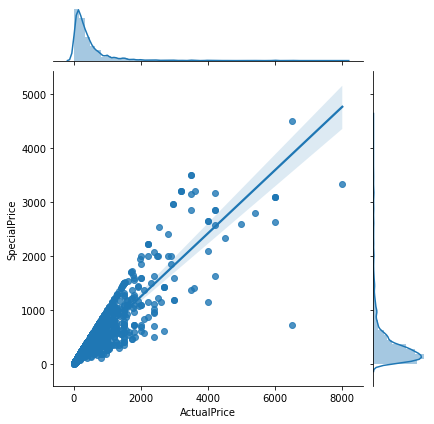

In [91]:
sns.jointplot(x="ActualPrice", y="SpecialPrice",kind="reg", data=df_all_platforms)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82084d13d0>,
      dtype=object)

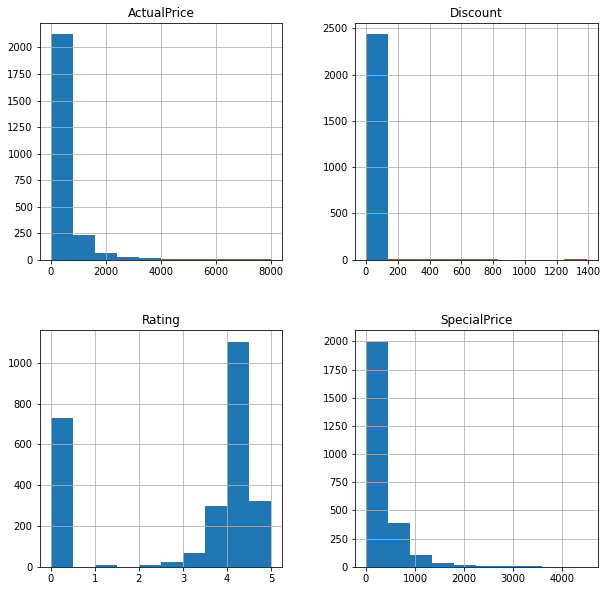

In [92]:
# checking the frequency distribution
df_all_platforms.hist(figsize=(10,10))

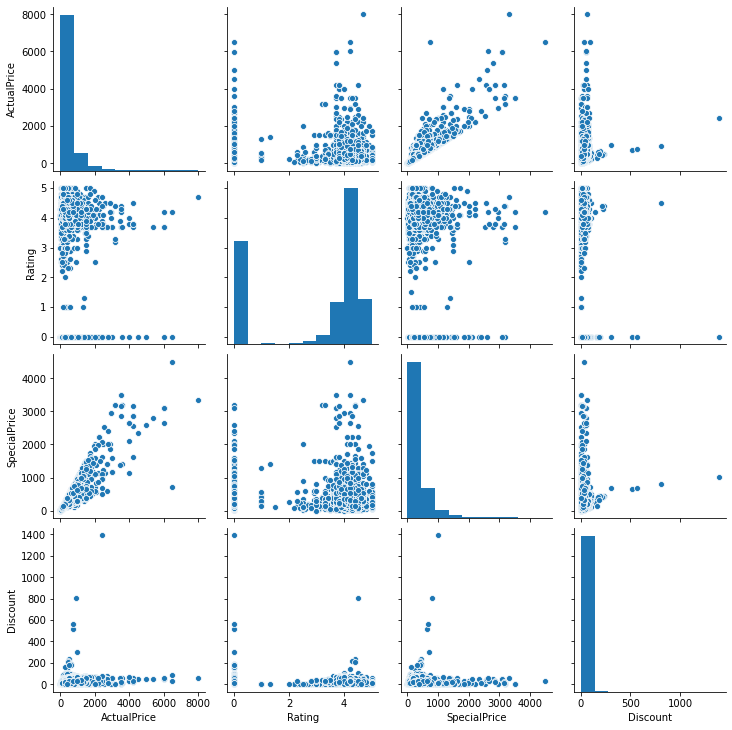

In [93]:
# For each pair of features (columns) in the dataset, we can visualize the scatter plot for each pair 
# along with the feature’s histogram along the diagonal
sns.pairplot(df_all_platforms[['ActualPrice','Rating','SpecialPrice','Discount']])

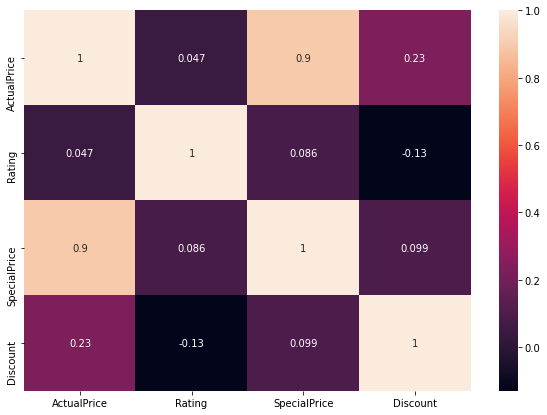

In [94]:
corr = df_all_platforms.corr()
fig = plt.figure(figsize=(10,7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

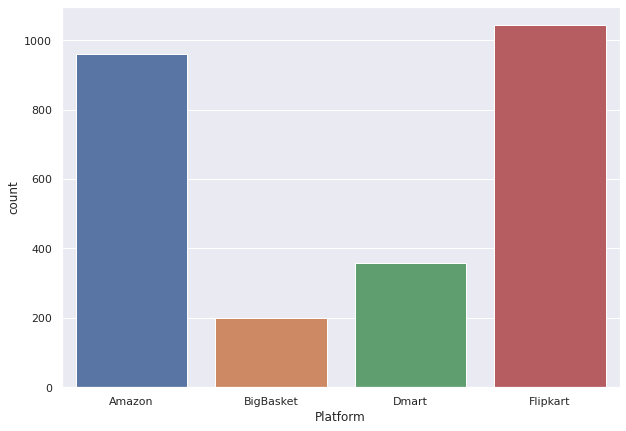

In [95]:
fig = plt.figure(figsize=(10,7))
sns.set()
ax = sns.countplot(x="Platform", data=df_all_platforms)

In [96]:
df_all_platforms.isna().any()

ProductName      True
ActualPrice      True
Rating          False
Category        False
SpecialPrice    False
Discount         True
IsAvailable     False
Platform        False
dtype: bool

In [97]:
df_all_platforms.isna().sum()

ProductName       1
ActualPrice     100
Rating            0
Category          0
SpecialPrice      0
Discount        114
IsAvailable       0
Platform          0
dtype: int64

In [98]:
df_all_platforms.isna().sum().sum()

215

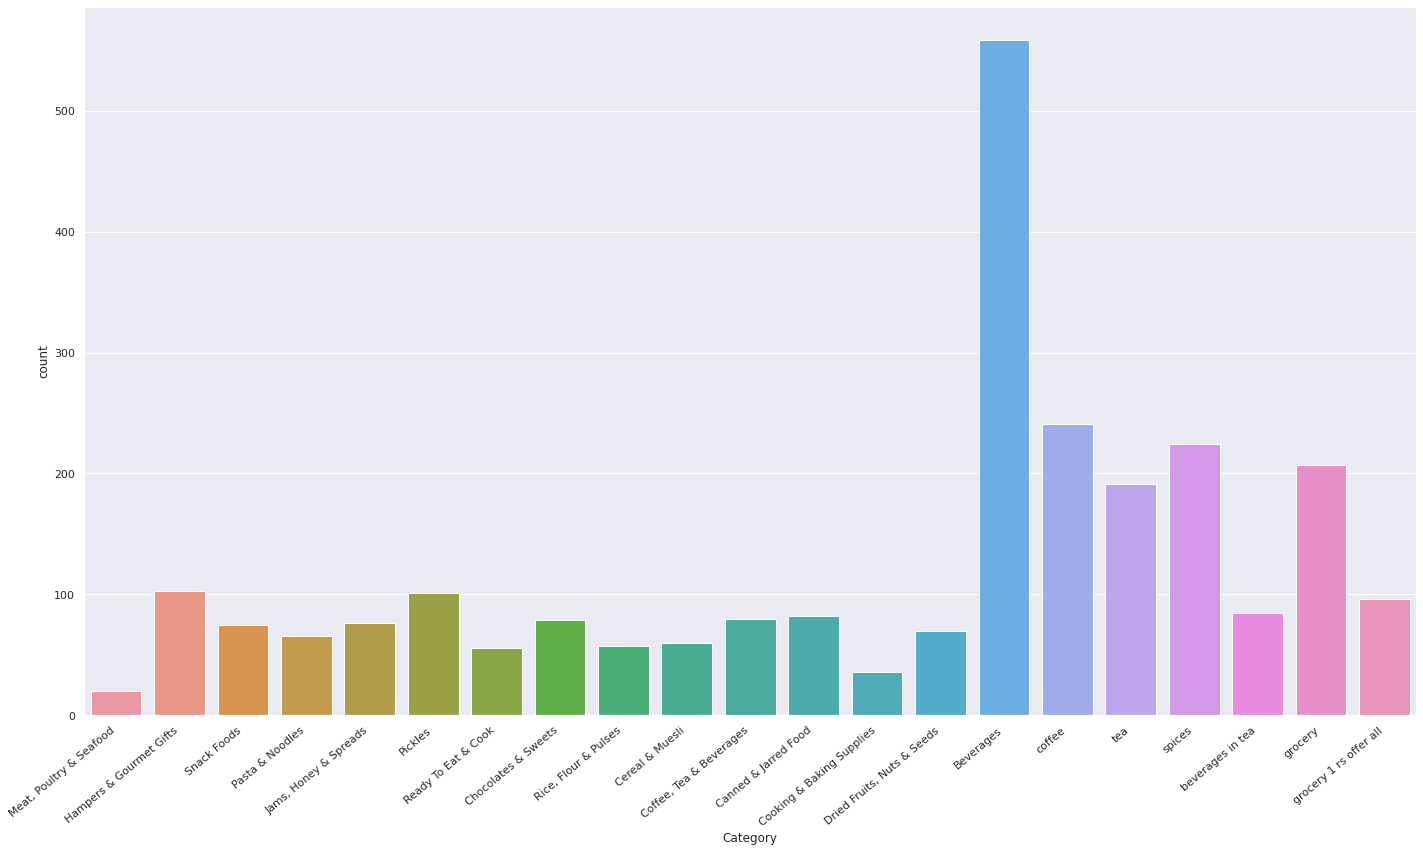

In [99]:
fig = plt.figure(figsize=(20,12))
ax = sns.countplot(x="Category", data=df_all_platforms)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

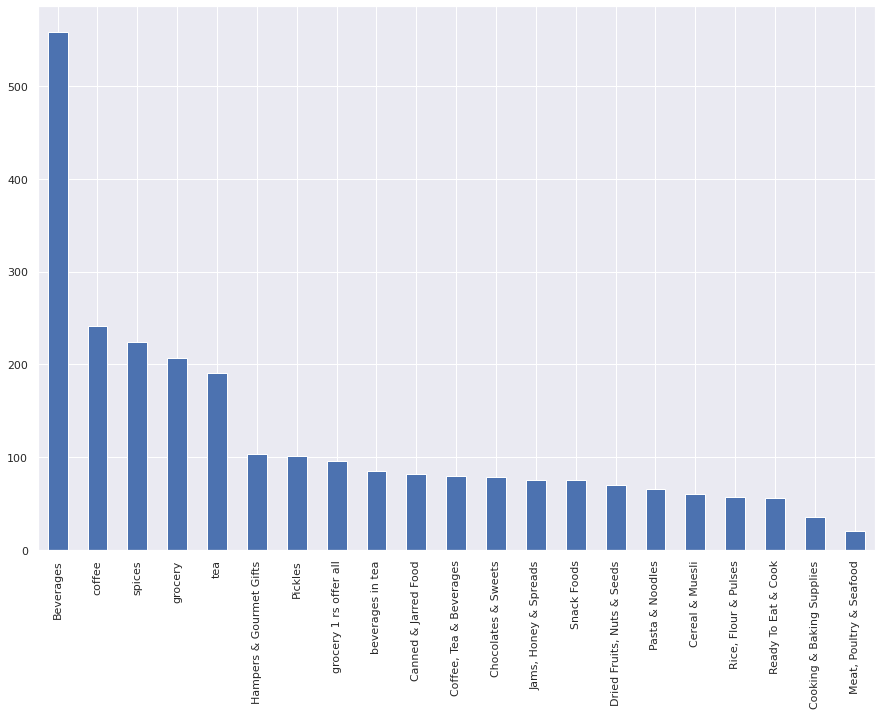

In [100]:
fig = plt.figure(figsize=(15,10))
df_all_platforms['Category'].value_counts().T.plot(kind='bar', stacked=True)

In [101]:
def search(sender):
    ''' recomending user based on special price and ratings. '''
    search_item = sender.value.lower()
    df_filtered = df_all_platforms[df_all_platforms['ProductName'].astype(str)\
                   .str.contains(search_item)].sort_values(by=['SpecialPrice'], ascending=[True])\
                .groupby(by=['Platform']).first()
    df = df_filtered.sort_values(by=['Rating'], ascending=[False]).copy()
    df.reset_index(inplace=True)
    df_top_product = df.iloc[0]
    msg = str.format('Recommended Platform : {0}', df_top_product.Platform)
    print(tabulate([[msg]], tablefmt='fancy_grid'))
    display(df)
    display(df[['Platform','Rating']].head(4).style.hide_index().highlight_max(color='lightgreen'))
    fig = plt.figure(figsize=(10,7))
    ax = sns.barplot(x="Platform", y="SpecialPrice", data=df, capsize=.2)

+---------------------------------------------------------------+
| Type the product name in below box and press enter to search. |
+---------------------------------------------------------------+


Text(value='')

╒══════════════════════════════════╕
│ Recommended Platform : BigBasket │
╘══════════════════════════════════╛


,Platform,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable
0,BigBasket,green tea - tulsi natura,60.0,4.5,Beverages,60.0,0.0,True
1,Amazon,"tetley green tea, ginger, mint and lemon, 100 tea bags",85.0,4.3,"Coffee, Tea & Beverages",85.0,0.0,True
2,Flipkart,onlyleaf 100% natural immunity boosting amla green tea ...,150.0,4.3,tea,110.0,12.0,False
3,Dmart,tea country original green tea : 25 tea-bags,99.0,0.0,Beverages,59.0,40.0,True


Platform,Rating
BigBasket,4.500000
Amazon,4.300000
Flipkart,4.300000
Dmart,0.000000


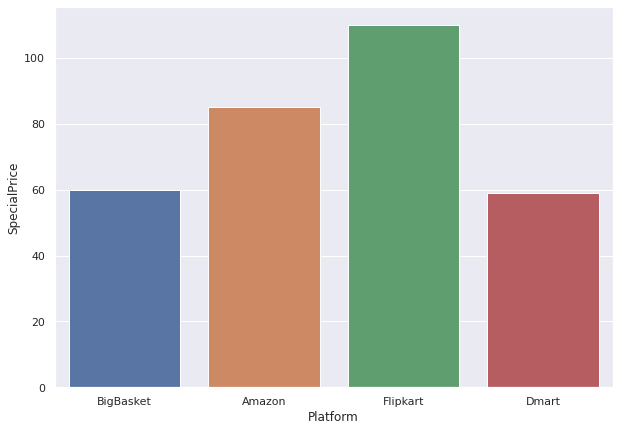

In [102]:
# recommending basedon price and ratings
text = widgets.Text()
print(tabulate([['Type the product name in below box and press enter to search.']], tablefmt='grid'))
display(text)
text.on_submit(search)

+---------------------------------------------------------------+
| Type the product name in below box and press enter to search. |
+---------------------------------------------------------------+


Text(value='')

╒═══════════════════════════════╕
│ Recommended Platform : Amazon │
╘═══════════════════════════════╛


,Platform,ProductName,ActualPrice,Rating,Category,SpecialPrice,Discount,IsAvailable
0,Amazon,red label natural care tea 1 kg,104.0,4.6,"Coffee, Tea & Beverages",104.0,0.0,True
1,Flipkart,red label tea box,195.0,4.4,beverages in tea,186.0,4.0,False
2,BigBasket,red label tea 500 gm carton + britannia 50-50 maska chaska biscuits 50 gm pouch,230.0,0.0,Beverages,230.0,0.0,True
3,Dmart,brooke bond red label natural care tea : 250 gms,135.0,0.0,Beverages,126.0,9.0,True


Platform,Rating
Amazon,4.600000
Flipkart,4.400000
BigBasket,0.000000
Dmart,0.000000


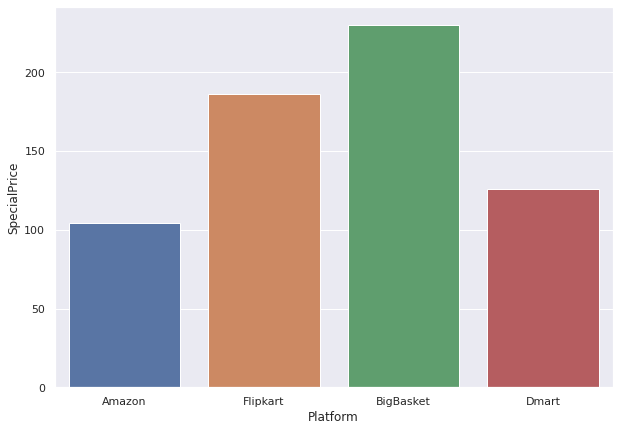

In [105]:
# recommended basedon price and ratings
text = widgets.Text()
print(tabulate([['Type the product name in below box and press enter to search.']], tablefmt='grid'))
display(text)
text.on_submit(search)

In [104]:
print('END OF NOTEBOOK')

END OF NOTEBOOK
